/Users/david/.ve/mce/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best bandwidth: 3.79269019073225


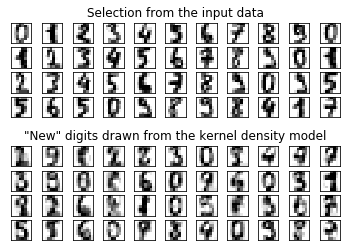

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# load the data
digits = load_digits()

# project the 64-dimensional data to a lower dimension
pca = PCA(n_components=15, whiten=False)
data = pca.fit_transform(digits.data)

# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params, cv=5)
grid.fit(data)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

# use the best estimator to compute the kernel density estimate
kde = grid.best_estimator_

# sample 44 new points from the data
new_data = kde.sample(44, random_state=0)
new_data = pca.inverse_transform(new_data)

# turn data into a 4x11 grid
new_data = new_data.reshape((4, 11, -1))
real_data = digits.data[:44].reshape((4, 11, -1))

# plot real digits and resampled digits
fig, ax = plt.subplots(9, 11, subplot_kw=dict(xticks=[], yticks=[]))
for j in range(11):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(real_data[i, j].reshape((8, 8)),
                             cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)
        im = ax[i + 5, j].imshow(new_data[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)

ax[0, 5].set_title('Selection from the input data')
ax[5, 5].set_title('"New" digits drawn from the kernel density model')

plt.show()

In [3]:
kde.__dict__.keys()

dict_keys(['algorithm', 'bandwidth', 'kernel', 'metric', 'atol', 'rtol', 'breadth_first', 'leaf_size', 'metric_params', 'tree_'])

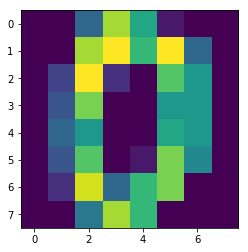

ValueError: query data dimension must match training data dimension

In [11]:
# compute LH for example

plt.imshow(digits['images'][0])
plt.show()

kde.score(digits['images'][0])

(1797, 64)

In [ ]:
##### MADE

"""
Implements Masked AutoEncoder for Density Estimation, by Germain et al. 2015
Re-implementation by Andrej Karpathy based on https://arxiv.org/abs/1502.03509
"""

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------------------------------------------------------------

class MaskedLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

class MADE(nn.Module):
    def __init__(self, nin, hidden_sizes, nout, num_masks=1, natural_ordering=False):
        """
        nin: integer; number of inputs
        hidden sizes: a list of integers; number of units in hidden layers
        nout: integer; number of outputs, which usually collectively parameterize some kind of 1D distribution
              note: if nout is e.g. 2x larger than nin (perhaps the mean and std), then the first nin
              will be all the means and the second nin will be stds. i.e. output dimensions depend on the
              same input dimensions in "chunks" and should be carefully decoded downstream appropriately.
              the output of running the tests for this file makes this a bit more clear with examples.
        num_masks: can be used to train ensemble over orderings/connections
        natural_ordering: force natural ordering of dimensions, don't use random permutations
        """
        
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.hidden_sizes = hidden_sizes
        assert self.nout % self.nin == 0, "nout must be integer multiple of nin"
        
        # define a simple MLP neural net
        self.net = []
        hs = [nin] + hidden_sizes + [nout]
        for h0,h1 in zip(hs, hs[1:]):
            self.net.extend([
                    MaskedLinear(h0, h1),
                    nn.ReLU(),
                ])
        self.net.pop() # pop the last ReLU for the output layer
        self.net = nn.Sequential(*self.net)
        
        # seeds for orders/connectivities of the model ensemble
        self.natural_ordering = natural_ordering
        self.num_masks = num_masks
        self.seed = 0 # for cycling through num_masks orderings
        
        self.m = {}
        self.update_masks() # builds the initial self.m connectivity
        # note, we could also precompute the masks and cache them, but this
        # could get memory expensive for large number of masks.
        
    def update_masks(self):
        if self.m and self.num_masks == 1: return # only a single seed, skip for efficiency
        L = len(self.hidden_sizes)
        
        # fetch the next seed and construct a random stream
        rng = np.random.RandomState(self.seed)
        self.seed = (self.seed + 1) % self.num_masks
        
        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = np.arange(self.nin) if self.natural_ordering else rng.permutation(self.nin)
        for l in range(L):
            self.m[l] = rng.randint(self.m[l-1].min(), self.nin-1, size=self.hidden_sizes[l])
        
        # construct the mask matrices
        masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        masks.append(self.m[L-1][:,None] < self.m[-1][None,:])
        
        # handle the case where nout = nin * k, for integer k > 1
        if self.nout > self.nin:
            k = int(self.nout / self.nin)
            # replicate the mask across the other outputs
            masks[-1] = np.concatenate([masks[-1]]*k, axis=1)
        
        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l,m in zip(layers, masks):
            l.set_mask(m)
    
    def forward(self, x):
        return self.net(x)

# ------------------------------------------------------------------------------

if __name__ == '__main__':
    from torch.autograd import Variable
    
    # run a quick and dirty test for the autoregressive property
    D = 10
    rng = np.random.RandomState(14)
    x = (rng.rand(1, D) > 0.5).astype(np.float32)
    
    configs = [
        (D, [], D, False),                 # test various hidden sizes
        (D, [200], D, False),
        (D, [200, 220], D, False),
        (D, [200, 220, 230], D, False),
        (D, [200, 220], D, True),          # natural ordering test
        (D, [200, 220], 2*D, True),       # test nout > nin
        (D, [200, 220], 3*D, False),       # test nout > nin
    ]
    
    for nin, hiddens, nout, natural_ordering in configs:
        
        print("checking nin %d, hiddens %s, nout %d, natural %s" % 
             (nin, hiddens, nout, natural_ordering))
        model = MADE(nin, hiddens, nout, natural_ordering=natural_ordering)
        
        # run backpropagation for each dimension to compute what other
        # dimensions it depends on.
        res = []
        for k in range(nout):
            xtr = Variable(torch.from_numpy(x), requires_grad=True)
            xtrhat = model(xtr)
            loss = xtrhat[0,k]
            loss.backward()
            
            depends = (xtr.grad[0].numpy() != 0).astype(np.uint8)
            depends_ix = list(np.where(depends)[0])
            isok = k % nin not in depends_ix
            
            res.append((len(depends_ix), k, depends_ix, isok))
        
        # pretty print the dependencies
        res.sort()
        for nl, k, ix, isok in res:
            print("output %2d depends on inputs: %30s : %s" % (k, ix, "OK" if isok else "NOTOK"))